# **How to Use Riveter** 💪

This Jupyter notebook will demonstrate how to use the Riveter package to measure social dynamics between personas mentioned in a collection of texts.

The package identifies and extracts the subjects, verbs, and direct objects in texts; it performs coreference resolution on the personas mentioned in the texts (e.g., clustering "Elizabeth Bennet" and "she" together as one persona); and it measures social dynamics between the personas by referencing a given lexicon. The package currently includes Maarten Sap et al's lexicon for power and agency and Rashkin et al's lexicon for perspective, effect, value, and mental state. 

<br><br><br><br>

## **Import libraries**

In [1]:
from collections import defaultdict
import os
import pandas as pd
import random
from riveter import Riveter

import seaborn as sns
import matplotlib.pyplot as plt


# SPACY & COREF IMPORTS
import spacy
import spacy_experimental
nlp = spacy.load("en_core_web_sm")
nlp_coref = spacy.load("en_coreference_web_trf")

# use replace_listeners for the coref components
nlp_coref.replace_listeners("transformer", "coref", ["model.tok2vec"])
nlp_coref.replace_listeners("transformer", "span_resolver", ["model.tok2vec"])

# we won't copy over the span cleaner
nlp.add_pipe("coref", source=nlp_coref)
nlp.add_pipe("span_resolver", source=nlp_coref)

/Users/mariaa/anaconda3/envs/riveterEnvExperimental/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


<br><br><br><br>

## **Small demo with Sap et al's Power and Agency Lexicon**

Here are three example stories that we will use to measure power and agency between personas:
> 1. I was just thinking about walking down the street, when my shoelace snapped. I had to call my doctor to pick me up. I felt so bad I also called my friend Katie, who came in her car. She was a lifesaver. My friend Jack is nice.

> 2. My doctor fixed my shoe. I thanked him. Then Susan arrived. Now she is calling the doctor too.

> 3. She went to the store. She thanked the doctor.

In [2]:
example_stories = ["I was just thinking about walking down the street, when a car hit a tree. I had to call my doctor to pick me up. I felt so bad I also called Katie, who came in her car. She saved me.",
                   "My doctor fixed my shoe. I thanked him. Then Susan arrived. Now she is calling the doctor too.",
                   "Mary went to the store. She thanked the doctor. He called her. He replied that it was no problem.",
                   "Jack broke the vase."]
text_ids = [0, 1, 2]

<br><br>

### Load lexicon ("power") and train model

In [3]:
riveter = Riveter()
riveter.load_sap_lexicon('power')
riveter.train(example_stories,
              text_ids)

 75%|███████▌  | 3/4 [00:00<00:00,  7.12it/s]

2023-07-26 21:39:54 Complete!


### Get total scores for all documents

You can use the `.get_score_totals()` function to get cumulative power scores (or chosen dynamic scores) for each persona mentioned in the texts.

In [4]:
riveter.get_score_totals(frequency_threshold=1)

{'i': -0.3,
 'she': 0.3333333333333333,
 'car': 1.0,
 'tree': -1.0,
 'doctor': 0.5,
 'mary': 0.0}

We can see all the contributing verbs for each persona and whether they contributed positively or negatively.

In [5]:
riveter.get_persona_polarity_verb_count_dict()

{'she': defaultdict(<function riveter.default_dict_int()>,
             {'positive': defaultdict(int, {'save_nsubj': 1})}),
 'car': defaultdict(<function riveter.default_dict_int()>,
             {'positive': defaultdict(int, {'hit_nsubj': 1})}),
 'i': defaultdict(<function riveter.default_dict_int()>,
             {'positive': defaultdict(int, {'call_dobj': 1}),
              'negative': defaultdict(int,
                          {'pick_dobj': 1,
                           'save_dobj': 1,
                           'thank_nsubj': 1,
                           'fix_dobj': 1})}),
 'tree': defaultdict(<function riveter.default_dict_int()>,
             {'negative': defaultdict(int, {'hit_dobj': 1})}),
 'doctor': defaultdict(<function riveter.default_dict_int()>,
             {'positive': defaultdict(int,
                          {'fix_nsubj': 1, 'thank_dobj': 2, 'call_dobj': 1}),
              'negative': defaultdict(int, {'call_nsubj': 1})}),
 'mary': defaultdict(<function riveter.defa

And we can view these scores visually for each persona. 

In the following heatmap, each cell contains the count of matching verbs for the persona that contributed either positively or negatively to its final score. 

(See examples later in the notebook for entities with more verbs). 

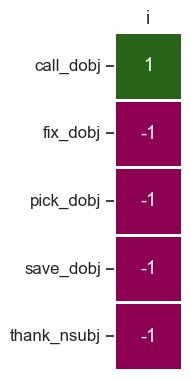

In [7]:
riveter.plot_verbs_for_persona('i', figsize=(2, 4))

We can save the Riveter object for later, and reload it when we want to use it again.

In [8]:
riveter.save('test')

Riveter successfully saved to "test"


You can also see what words or names have been clustered together for each persona (performed by the coreference resolution model).

In [9]:
riveter.get_persona_cluster('doctor')

{'my doctor fixed': 1,
 'him.': 1,
 'the doctor too': 1,
 'the doctor.': 1,
 'he called': 1,
 'he replied': 1}

In [10]:
riveter.get_persona_cluster('susan')

{'susan arrived': 1, 'she is': 1}

In [11]:
riveter.get_persona_cluster('i')

{'i was': 1,
 'i had': 1,
 'my doctor': 2,
 'me up': 1,
 'i felt': 1,
 'i also': 1,
 'me.': 1,
 'my shoe': 1,
 'i thanked': 1}

### Plot scores for all documents

You can use the `.plot_scores()` function to display a bar plot with the top *n* or bottom *n* personas in the texts. The function will display the top 10 highest-scoring personas by default.

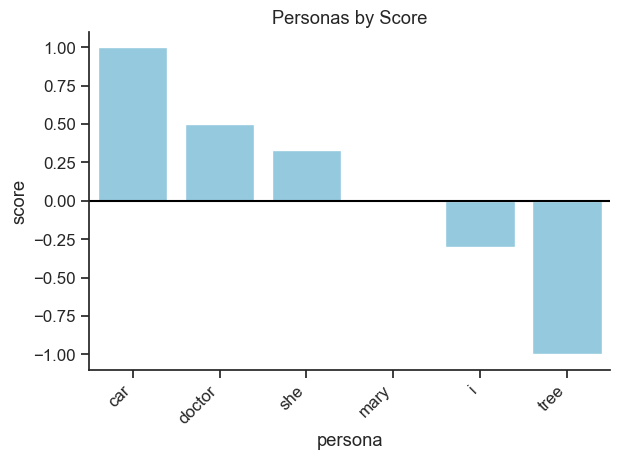

In [12]:
riveter.plot_scores(frequency_threshold=0)

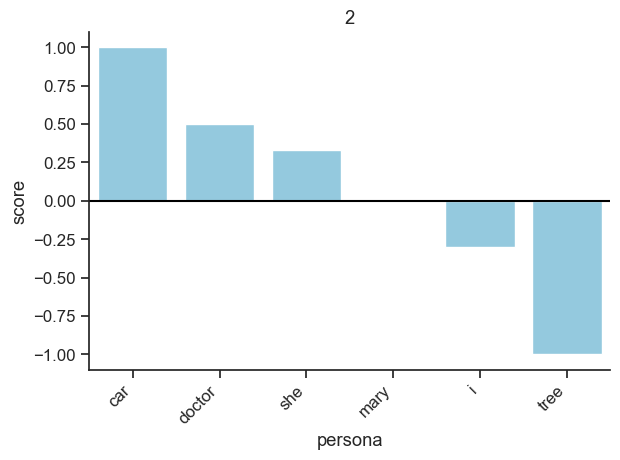

In [13]:
riveter.plot_scores(2)

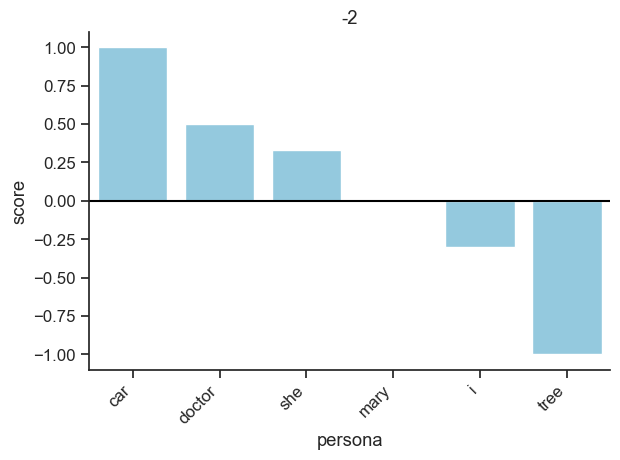

In [14]:
riveter.plot_scores(-2)

### Get scores, subjects, and direct objects for each document

You can use the `.get_score_for_doc()` function to get power scores (or chosen dynamic scores) for each persona mentioned in a document (based on the document id passed into the training function).

In [15]:
example_stories[0]

'I was just thinking about walking down the street, when a car hit a tree. I had to call my doctor to pick me up. I felt so bad I also called Katie, who came in her car. She saved me.'

In [16]:
riveter.get_scores_for_doc(0)

{'i': -0.2, 'she': 1.0, 'car': 1.0, 'tree': -1.0}

You can use `.count_nsubj_for_doc()` to get all noun subjects and verb pairs (regardless of whether the verb apperas in the chosen lexicon) for each document.

In [17]:
riveter.count_nsubj_for_doc(0)

{('i', 'have'): 1, ('i', 'feel'): 1, ('she', 'save'): 1, ('car', 'hit'): 1}

You can use `.count_dobj_for_doc()` to get all direct objects and verb pairs (regardless of whether the verb apperas in the chosen lexicon) for each document.

In [18]:
riveter.count_dobj_for_doc(0)

{('i', 'call'): 1, ('i', 'pick'): 1, ('i', 'save'): 1, ('tree', 'hit'): 1}

### Plot scores for each document

You can use the `.plot_scores_for_doc()` function to display a bar plot with the top *n* or bottom *n* personas in a specified document. The function will display the top 10 highest-scoring personas by default.

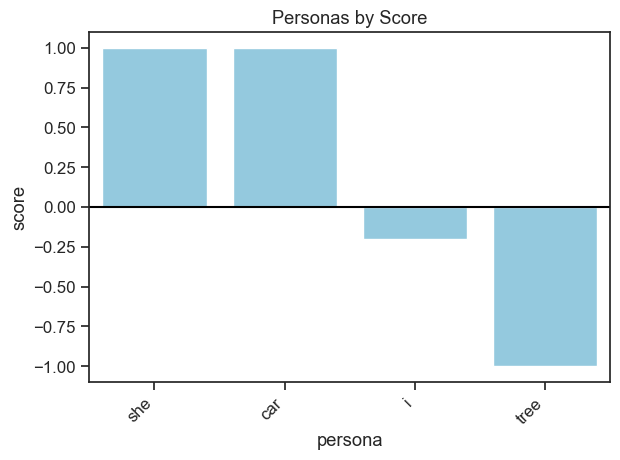

In [19]:
riveter.plot_scores_for_doc(0)

### Use regular expressions in place of entity extraction and coreference resolution

Instead of discovering all the entities automatically, you can define a regular expression to capture patterns for each entity. You will need to determine these entities and patterns yourself.

In [20]:
riveter.train(example_stories,
              text_ids,
              persona_patterns_dict={'first person singular': r'^i$|^me$'})

 75%|███████▌  | 3/4 [00:00<00:00, 11.99it/s]

2023-07-26 18:51:33 Complete!


In [21]:
riveter.get_score_totals()

{'first person singular': -0.5714285714285714}

### Use agency lexicon instead of power

In [22]:
riveter = Riveter()
riveter.load_sap_lexicon('agency')
riveter.train(example_stories,
              text_ids)

 75%|███████▌  | 3/4 [00:00<00:00, 12.47it/s]

2023-07-26 18:51:34 Complete!


In [23]:
riveter.get_score_totals()

{'i': 0.1,
 'she': 0.3333333333333333,
 'car': 1.0,
 'tree': 0.0,
 'doctor': 0.16666666666666666,
 'susan': 0.0,
 'mary': 0.3333333333333333}

<br><br><br><br>

## **Small demo w/ Rashkin frames**

This example is similar to the first example, but here, we'll use Rashkin et al's sentiment frames instead of the power and agency frames we used above.

In [24]:
example_stories = ["I was just thinking about walking down the street, when my shoelace snapped. I had to call my doctor to pick me up. I felt so bad I also called my friend Katie, who came in her car. She was a lifesaver. My friend Jack is nice.",
                   "My doctor fixed my shoe. I thanked him. Then Susan arrived. Now she is calling the doctor too."]
text_ids = [0, 1]

In [25]:
riveter = Riveter()
riveter.load_rashkin_lexicon('effect')
riveter.train(example_stories,
              text_ids)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10.91it/s]

2023-07-26 18:51:37 Complete!


In [26]:
riveter.get_score_totals()

{'i': 0.20555555555566665,
 'she': 0.088888888889,
 'doctor': 0.3777777777776667,
 'susan': 0.0666666666665}

In [27]:
riveter.get_scores_for_doc(0)

{'i': 0.2800000000002, 'she': 0.1333333333335}

In [28]:
riveter.get_scores_for_doc(1)

{'i': 0.5333333333335, 'doctor': 0.3777777777776667, 'susan': 0.133333333333}

In [29]:
riveter = Riveter()
riveter.load_rashkin_lexicon('value')
riveter.train(example_stories,
              text_ids)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 11.46it/s]

2023-07-26 18:51:38 Complete!


In [30]:
riveter.get_score_totals()

{'i': 0.4277777777778333,
 'she': 0.288888888889,
 'doctor': 0.7777777777780001,
 'susan': 0.2333333333335}

<br><br><br><br>

## **Small demo w/ custom frames**

This example is similar to the first example, but here, we'll use a custom lexicon. You can follow this pattern to use your own lexicon.

(In this case, our "custom lexicon" is actually just a copy of the Rashkin lexicon.)

In [31]:
example_stories = ["I was just thinking about walking down the street, when my shoelace snapped. I had to call my doctor to pick me up. I felt so bad I also called my friend Katie, who came in her car. She was a lifesaver. My friend Jack is nice.",
                   "My doctor fixed my shoe. I thanked him. Then Susan arrived. Now she is calling the doctor too."]
text_ids = [0, 1]

In [32]:
riveter = Riveter()
riveter.load_custom_lexicon(lexicon_path='data/example-custom-lexicon/full_frame_info.tsv', 
                            verb_column='verb',
                            agent_column='effect(a)',
                            theme_column='effect(t)')
riveter.train(example_stories,
              text_ids)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10.56it/s]

2023-07-26 18:51:41 Complete!


In [33]:
riveter.get_score_totals()

{'i': 0.20555555555566665,
 'she': 0.088888888889,
 'doctor': 0.3777777777776667,
 'susan': 0.0666666666665}

In [34]:
riveter.get_scores_for_doc(0)

{'i': 0.2800000000002, 'she': 0.1333333333335}

In [35]:
riveter.get_scores_for_doc(1)

{'i': 0.5333333333335, 'doctor': 0.3777777777776667, 'susan': 0.133333333333}

In [36]:
riveter = Riveter()
riveter.load_rashkin_lexicon('value')
riveter.train(example_stories,
              text_ids)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 2/2 [00:00<00:00, 10.44it/s]

2023-07-26 18:51:42 Complete!


In [37]:
riveter.get_score_totals()

{'i': 0.4277777777778333,
 'she': 0.288888888889,
 'doctor': 0.7777777777780001,
 'susan': 0.2333333333335}

<br><br><br><br>

## **Bigger demo w/ Sap frames for _Pride and Prejudice_**

Here we show a larger, more realistic example for the Jane Austen novel. 

We'll try both discovering entities automatically and using regular expressions to capture pronoun groups.

### Load data

In [2]:
lines = [_line.strip() for _line in open('data/pride_and_prejudice.txt', 'r')]
texts = ['']
for _line in lines:
    if _line.strip():
        texts[-1] += ' ' + _line
    else:
        texts[-1] = texts[-1].strip()
        texts.append('')
text_ids = [i for i, t in enumerate(texts)]

len(texts), len(text_ids)

(2791, 2791)

### Explore using discovered entities (using entity recognition and coreference resolution)

In [3]:
riveter = Riveter()
riveter.load_sap_lexicon('power')
riveter.train(texts,
              text_ids,
              num_bootstraps=10)

100%|██████████| 2791/2791 [05:11<00:00,  8.96it/s]

2023-07-26 21:51:41 Complete!


In [4]:
riveter.save('/Users/mariaa/Desktop/riveter.pride_and_prejudice.pkl')

Riveter successfully saved to "/Users/mariaa/Desktop/riveter.pride_and_prejudice.pkl"


In [5]:
persona_score_dict = riveter.get_score_totals(frequency_threshold=20)
len(persona_score_dict)

40

In [6]:
for _persona, _score in sorted(persona_score_dict.items(), key=lambda x: x[1], reverse=True):
    print(round(_score, 2), '\t', _persona)

0.12 	 brother
0.12 	 miss bingley
0.1 	 we
0.09 	 mr. wickham
0.08 	 bingley
0.07 	 jane
0.07 	 nothing
0.05 	 wickham
0.04 	 mr. bennet
0.04 	 lady catherine
0.02 	 they
0.02 	 _
0.02 	 it
0.02 	 place
0.02 	 lydia
-0.01 	 darcy
-0.02 	 her
-0.04 	 letter
-0.05 	 dear
-0.07 	 mrs. bennet
-0.07 	 uncle
-0.07 	 them
-0.07 	 you
-0.07 	 i
-0.08 	 she
-0.1 	 elizabeth
-0.11 	 charlotte
-0.11 	 sister
-0.12 	 him
-0.13 	 something
-0.14 	 charge
-0.15 	 mr. darcy
-0.15 	 he
-0.16 	 mr. collins
-0.2 	 colonel forster
-0.2 	 me
-0.21 	 mother
-0.24 	 father
-0.26 	 mr. bingley
-0.32 	 anything


In [7]:
persona_polarity_verb_count_dict = riveter.get_persona_polarity_verb_count_dict()
len(persona_polarity_verb_count_dict)

1388

In [8]:
persona_polarity_verb_count_dict['mr. gardiner']

defaultdict(<function riveter.default_dict_int()>,
            {'positive': defaultdict(int,
                         {'express_nsubj': 1,
                          'leave_nsubj': 1,
                          'thank_dobj': 1,
                          'add_nsubj': 2,
                          'do_nsubj': 2}),
             'negative': defaultdict(int,
                         {'leave_dobj': 1,
                          'watch_dobj': 1,
                          'settle_dobj': 1})})

In [9]:
persona_polarity_verb_count_dict['elizabeth']

defaultdict(<function riveter.default_dict_int()>,
            {'negative': defaultdict(int,
                         {'catch_dobj': 1,
                          'listen_nsubj': 4,
                          'injure_dobj': 1,
                          'quit_dobj': 1,
                          'restore_dobj': 1,
                          'thank_nsubj': 1,
                          'fetch_dobj': 1,
                          'leave_dobj': 3,
                          'station_dobj': 1,
                          'join_nsubj': 1,
                          'direct_dobj': 2,
                          'wonder_nsubj': 3,
                          'check_dobj': 2,
                          'hope_nsubj': 3,
                          'divert_dobj': 1,
                          'strike_dobj': 2,
                          'give_dobj': 2,
                          'alarm_dobj': 1,
                          'blame_dobj': 2,
                          'influence_dobj': 1,
                          'turn_

In [10]:
persona_polarity_verb_count_dict['darcy']

defaultdict(<function riveter.default_dict_int()>,
            {'positive': defaultdict(int,
                         {'acknowledge_nsubj': 1,
                          'sell_nsubj': 1,
                          'dare_nsubj': 1,
                          'oblige_dobj': 1,
                          'make_nsubj': 2,
                          'turn_nsubj': 1,
                          'arrange_nsubj': 1,
                          'believe_dobj': 1,
                          'beg_dobj': 1,
                          'congratulate_dobj': 1,
                          'determine_nsubj': 1,
                          'shake_nsubj': 1,
                          'mention_dobj': 1,
                          'like_dobj': 1,
                          'do_nsubj': 1}),
             'negative': defaultdict(int,
                         {'add_dobj': 2,
                          'plan_dobj': 1,
                          'strike_dobj': 1,
                          'recommend_dobj': 2,
                     

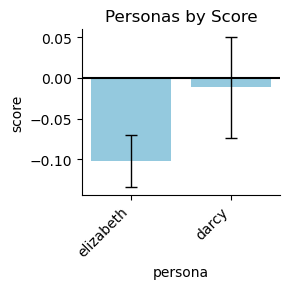

In [11]:
riveter.plot_scores(title='Personas by Score', target_personas=['elizabeth', 'darcy'], figsize=(3, 3))

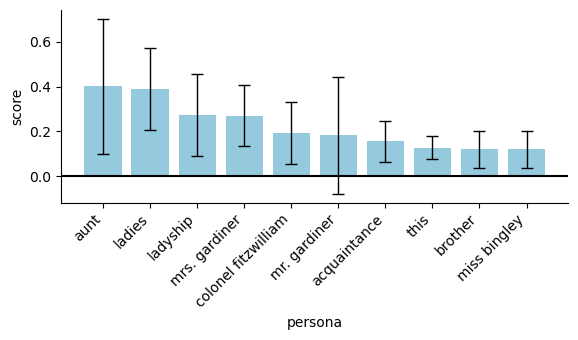

In [12]:
riveter.plot_scores(title='', 
                    frequency_threshold=10, 
                    number_of_scores=10, 
                    figsize=(6,3.5),
                    output_path='/Users/mariaa/Desktop/barplot.pride_and_prejudice.most_power.pdf')

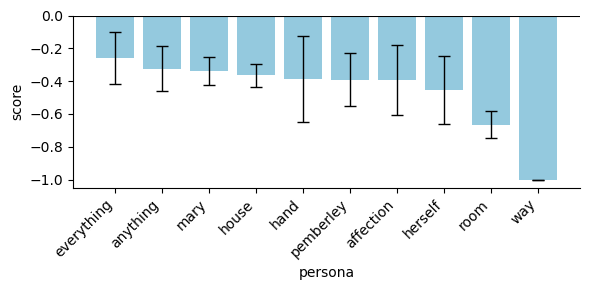

In [13]:
riveter.plot_scores(title='', 
                    frequency_threshold=10, 
                    number_of_scores=-10, 
                    figsize=(6,3),
                    output_path='/Users/mariaa/Desktop/barplot.pride_and_prejudice.least_power.pdf')

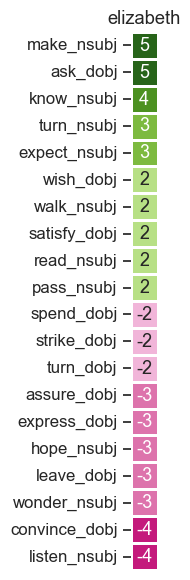

In [14]:
riveter.plot_verbs_for_persona('elizabeth', figsize=(2,6), output_path='/Users/mariaa/Desktop/heatmap.pride_and_prejudice.elizabeth.pdf')

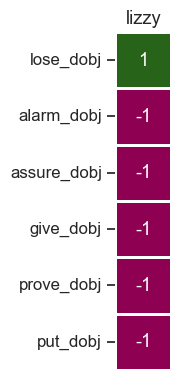

In [15]:
riveter.plot_verbs_for_persona('lizzy', figsize=(2,4), output_path='/Users/mariaa/Desktop/heatmap.pride_and_prejudice.lizzy.pdf')

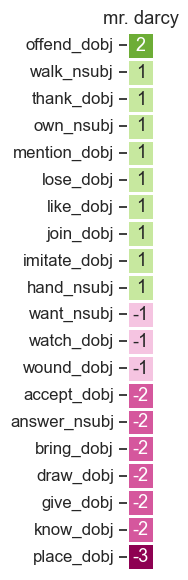

In [16]:
riveter.plot_verbs_for_persona('mr. darcy', figsize=(2,6), output_path='/Users/mariaa/Desktop/heatmap.pride_and_prejudice.mrdarcy.pdf')

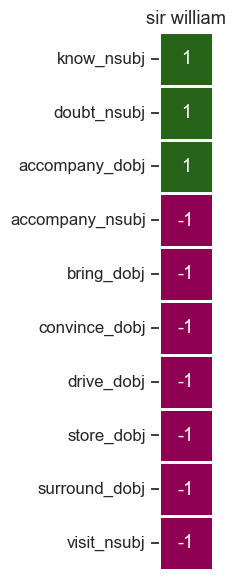

In [17]:
riveter.plot_verbs_for_persona('sir william', figsize=(2,6), output_path='/Users/mariaa/Desktop/heatmap.pride_and_prejudice.sirwilliam.pdf')

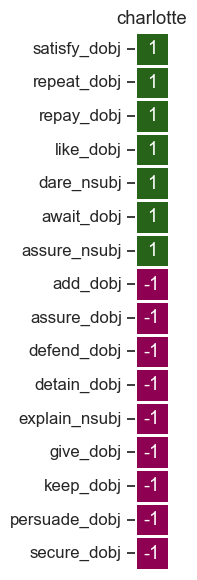

In [18]:
riveter.plot_verbs_for_persona('charlotte', figsize=(2,6), output_path='/Users/mariaa/Desktop/heatmap.pride_and_prejudice.misslucas.pdf')

In [20]:
matched_ids, matched_texts = riveter.get_documents_for_persona('charlotte')
for t in matched_texts[:10]:
    print(t)
    print()

“It may, perhaps, be pleasant,” replied Charlotte, “to be able to impose on the public in such a case; but it is sometimes a disadvantage to be so very guarded. If a woman conceals her affection with the same skill from the object of it, she may lose the opportunity of fixing him; and it will then be but poor consolation to believe the world equally in the dark. There is so much of gratitude or vanity in almost every attachment, that it is not safe to leave any to itself. We can all _begin_ freely--a slight preference is natural enough; but there are very few of us who have heart enough to be really in love without encouragement. In nine cases out of ten, a woman had better show _more_ affection than she feels. Bingley likes your sister undoubtedly; but he may never do more than like her, if she does not help him on.”

When the dancing recommenced, however, and Darcy approached to claim her hand, Charlotte could not help cautioning her, in a whisper, not to be a simpleton, and allow he

### Explore using regular expressions to capture pronouns

In [39]:
riveter = Riveter()
riveter.load_sap_lexicon('power')
riveter.train(texts,
             text_ids,
             num_bootstraps=20,
             persona_patterns_dict={'masculine': r'^he$|^him$|^himself$',
                                    'feminine': r'^she$|^her$|^herself$',
                                    'third plural': r'^they$|^them$|^themselves$'})

100%|██████████| 2791/2791 [05:16<00:00,  8.80it/s]

2023-07-26 21:38:58 Complete!


In [40]:
persona_score_dict = riveter.get_score_totals()
len(persona_score_dict)

3

In [41]:
for _persona, _score in sorted(persona_score_dict.items(), key=lambda x: x[1], reverse=True):
    print(round(_score, 3), '\t', _persona)

0.082 	 third plural
0.044 	 masculine
0.024 	 feminine


In [42]:
persona_polarity_verb_count_dict = riveter.get_persona_polarity_verb_count_dict()
len(persona_polarity_verb_count_dict)

3

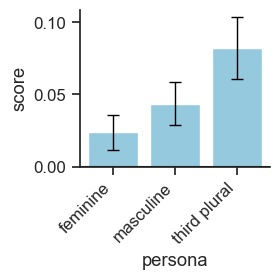

In [43]:
riveter.plot_scores(number_of_scores=10, 
                    title='', 
                    target_personas=['masculine', 'feminine', 'third plural'],
                    figsize=(3,3),
                    output_path='/Users/mariaa/Desktop/barplot.prideandprejudice.pronouns.pdf')

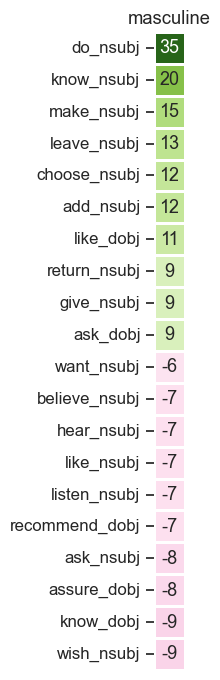

In [44]:
riveter.plot_verbs_for_persona('masculine', figsize=(3,7), output_path='/Users/mariaa/Desktop/heatmap.prideandprejudice.masculine.pdf')

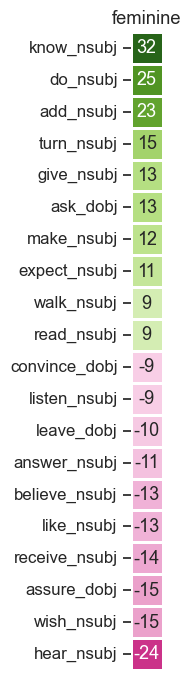

In [45]:
riveter.plot_verbs_for_persona('feminine', figsize=(3,7), output_path='/Users/mariaa/Desktop/heatmap.prideandprejudice.feminine.pdf')

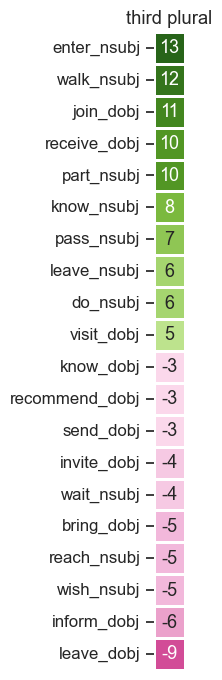

In [46]:
riveter.plot_verbs_for_persona('third plural', figsize=(3,7), output_path='/Users/mariaa/Desktop/heatmap.prideandprejudice.thirdplural.pdf')

In [47]:
matched_ids, matched_texts = riveter.get_documents_for_persona('feminine')
for t in matched_texts[:10]:
    print(t)
    print()

“But it is,” returned she; “for Mrs. Long has just been here, and she told me all about it.”

“I desire you will do no such thing. Lizzy is not a bit better than the others: and I am sure she is not half so handsome as Jane, nor half so good-humoured as Lydia. But you are always giving _her_ the preference.”

Mr. Bennet was so odd a mixture of quick parts, sarcastic humour, reserve, and caprice, that the experience of three-and-twenty years had been insufficient to make his wife understand his character. _Her_ mind was less difficult to develope. She was a woman of mean understanding, little information, and uncertain temper. When she was discontented, she fancied herself nervous. The business of her life was to get her daughters married: its solace was visiting and news.

“No more have I,” said Mr. Bennet; “and I am glad to find that you do not depend on her serving you.”

Mrs. Bennet deigned not to make any reply; but, unable to contain herself, began scolding one of her daughters.



In [48]:
matched_ids, matched_texts = riveter.get_documents_for_persona('masculine')
for t in matched_texts[:10]:
    print(t)
    print()

“Design? Nonsense, how can you talk so! But it is very likely that he _may_ fall in love with one of them, and therefore you must visit him as soon as he comes.”

“But consider your daughters. Only think what an establishment it would be for one of them. Sir William and Lady Lucas are determined to go, merely on that account; for in general, you know, they visit no new comers. Indeed you must go, for it will be impossible for _us_ to visit him, if you do not.”

“You are over scrupulous, surely. I dare say Mr. Bingley will be very glad to see you; and I will send a few lines by you to assure him of my hearty consent to his marrying whichever he chooses of the girls--though I must throw in a good word for my little Lizzy.”

“They have none of them much to recommend them,” replied he: “they are all silly and ignorant like other girls; but Lizzy has something more of quickness than her sisters.”

Mr. Bennet was among the earliest of those who waited on Mr. Bingley. He had always intended t

In [49]:
matched_ids, matched_texts = riveter.get_documents_for_verb('hear')
for t in matched_texts[:10]:
    print(t)
    print()

In a few days Mr. Bingley returned Mr. Bennet’s visit, and sat about ten minutes with him in his library. He had entertained hopes of being admitted to a sight of the young ladies, of whose beauty he had heard much; but he saw only the father. The ladies were somewhat more fortunate, for they had the advantage of ascertaining, from an upper window, that he wore a blue coat and rode a black horse.

“I do not believe a word of it, my dear. If he had been so very agreeable, he would have talked to Mrs. Long. But I can guess how it was; everybody says that he is eat up with pride, and I dare say he had heard somehow that Mrs. Long does not keep a carriage, and had to come to the ball in a hack chaise.”

Elizabeth joined them again only to say that her sister was worse, and that she could not leave her. Bingley urged Mr. Jones’s being sent for immediately; while his sisters, convinced that no country advice could be of any service, recommended an express to town for one of the most eminent 